In [319]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
def f(x):
    return 4*x**2-5*x+6

In [18]:
f(3.0)

27.0

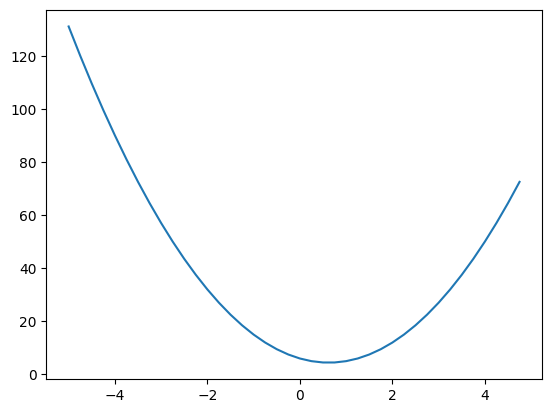

In [20]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [23]:
h = 0.01
x = 3.0
(f(x+h) - f(x))/ h

19.03999999999968

In [246]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data={self.data})"

    # addition
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        self._backward = _backward
        return out

    # multiplication.
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        self._backward = _backward
        return out

    # power
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self, ), f'**{other}')
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        self._backward = _backward
        return out

    # reverse multiplication.
    def __rmul__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1

    def __neg__(self):
        return self * -1

    def __radd__(self, other):
        return self + other

    # substraction.
    def __sub__(self, other):
        return self + (-other)

    # tanh - activation function.
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        self._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        def _backward():
            self.grad += out.data * out.grad # reuse math.exp(x) value as out.data
        self._backward = _backward
        return out

    # backward
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
            for child in v._prev:
              build_topo(child)
            topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [247]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges
def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape="record")
        if n._op:
            dot.node(name = uid + n._op, label=n._op)
            dot.edge(uid+n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

In [248]:
a = Value(2.0, label='a')
b = Value(3.0, label='b')
c = Value(5.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = d.tanh(); f.label = 'f'
print(f)

Value(data=0.9999999994421064)


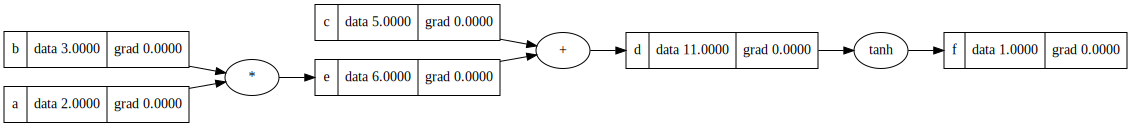

In [236]:
draw_dot(f)

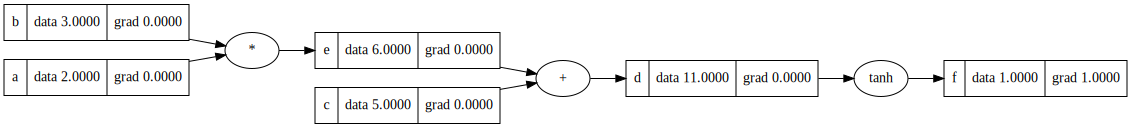

In [305]:
f.backward()
draw_dot(f)

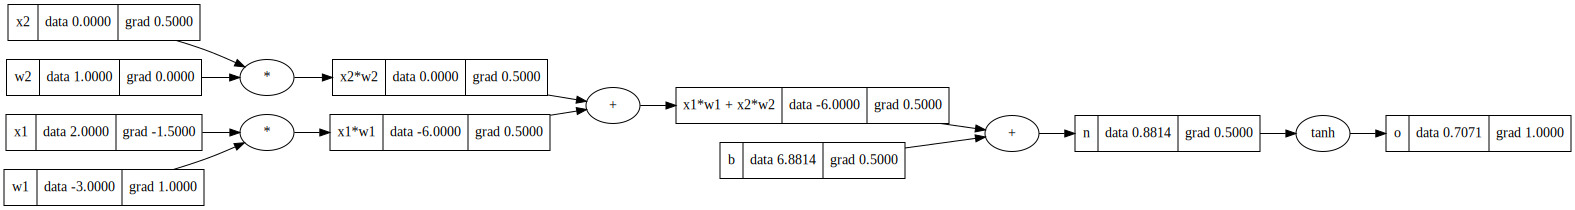

In [302]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# using tanh
o = n.tanh(); o.label = 'o'
o.backward()
draw_dot(o)

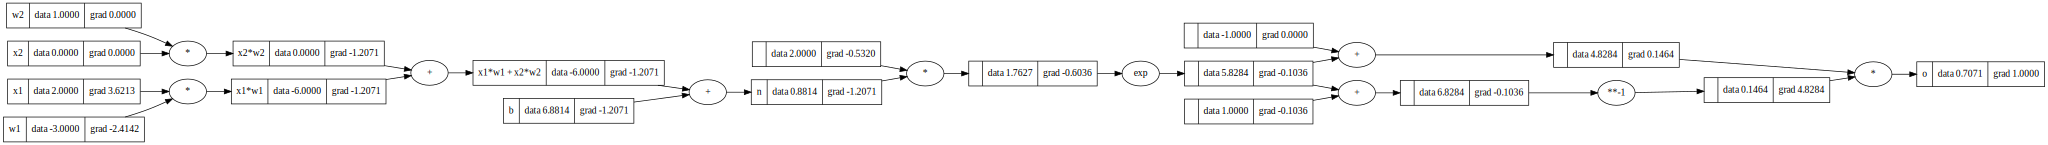

In [304]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# using exp
e = (2*n).exp()
o = (e - 1) / (e + 1)
# using exp
o.label = 'o'
o.backward()
draw_dot(o)

In [252]:
import torch

In [310]:
x1 = torch.Tensor([2.0]).double()              ;x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()              ;x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()             ;w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()              ;w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double();b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = n.tanh()
o.backward()

print(o.data.item())
print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())


0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [356]:
# Define Neuron, init, call, parameters
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out 

    def parameters(self):
        return [self.b] + self.w

# define Layer, init call, parameters
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
# define MLP, init, call, parameter.
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        

In [369]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.6560023958386633)

In [370]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [393]:
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass  
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += 0.1 * p.grad
  
  print(k, loss.data)

0 8.0
1 8.0
2 8.0
3 8.0
4 8.0
5 8.0
6 8.0
7 8.0
8 8.0
9 8.0
10 8.0
11 8.0
12 8.0
13 8.0
14 8.0
15 8.0
16 8.0
17 8.0
18 8.0
19 8.0


In [392]:
ypred

[Value(data=1.0), Value(data=1.0), Value(data=1.0), Value(data=1.0)]